In [12]:
import sys; sys.path.append("..")
from dotenv import load_dotenv; load_dotenv()

True

# Improving the RAG Application

## Logging requests

In order to improve the performance of the RAG application it is crucial that we log each request so we can study what to improve. To make parsing of the data easier, we use the Python `structlog` package. First we need to configure the logging, which happens in `rag/serve.py`. We are storing the logs in a network file system, configured via the `RAY_ASSISTANT_LOGS` environment variable and make sure a timestamp is written for each log line. The logs are then rendered as JSON lines and written to the log file:

```python
# Configure logging
logging.basicConfig(filename=os.environ["RAY_ASSISTANT_LOGS"], level=logging.INFO, encoding='utf-8')
structlog.configure(
    processors=[
        structlog.processors.TimeStamper(fmt="iso"),
        structlog.processors.JSONRenderer(),
    ],
    logger_factory=structlog.stdlib.LoggerFactory(),
)
logger = structlog.get_logger()
```

The actual call that records the log then looks like the following:

```python
logger.info(
    "finished streaming query",
    query=query,
    document_ids=result["document_ids"],
    llm=result["llm"],
    answer=answer
)
```

Depending on your application, it might make sense to add more fields to the logs -- we are logging the user's `query`, the document IDs retrieved from the database that make up the context as well as the LLM that was used for answering the query.

## Evaluating the data

In [4]:
import json

records = []
log_prefix = "INFO:rag.serve:"
with open("/mnt/shared_storage/ray-assistant-logs/info.copy") as f:
    records = [json.loads(line.removeprefix(log_prefix)) for line in f if line.startswith(log_prefix)]

In [14]:
import pandas as pd

df = pd.DataFrame.from_records(records)
df['timestamp']= pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [15]:
df

,query,document_ids,llm,answer,event
timestamp,,,,,
2023-09-16 05:56:12.792456+00:00,Give me a code example for creating an actor.,"[3689, 9659, 3746, 11936, 3854, 4549, 3748]",gpt-4,Here is a Python code example for creating an ...,finished streaming query
2023-09-16 06:04:57.823437+00:00,What is Ray?,"[4538, 3471, 11362, 8371, 4445, 8271, 5358]",meta-llama/Llama-2-70b-chat-hf,Ray is a framework for running arbitrary code ...,finished streaming query
2023-09-16 06:13:44.251850+00:00,How can I read all text files from the bucket ...,"[6102, 6388, 6571, 6706, 7458, 5701, 6188]",meta-llama/Llama-2-70b-chat-hf,"To read all text files from the bucket ""s3://r...",finished streaming query
2023-09-16 06:14:15.046320+00:00,How can I read all text files from the bucket ...,"[6706, 6187, 6188, 6102, 6140, 6388, 6571]",meta-llama/Llama-2-70b-chat-hf,Sure! Here's a succinct answer to the query:\n...,finished streaming query
2023-09-16 06:14:31.911983+00:00,How can I read all text files from the bucket ...,"[6706, 6102, 6187, 6388, 6188, 5685, 6140]",meta-llama/Llama-2-70b-chat-hf,"To read all text files from the bucket ""s3://r...",finished streaming query
...,...,...,...,...,...
2023-09-26 22:39:06.602940+00:00,how to install all ray dependencies at once\n\n,"[4568, 8012, 3550, 640, 461]",meta-llama/Llama-2-70b-chat-hf,"To install all Ray dependencies at once, you ...",finished streaming query
2023-09-26 22:46:16.754912+00:00,what are the different Trainers available?,"[12001, 7375, 7087, 7043, 7001]",meta-llama/Llama-2-70b-chat-hf,The different Trainers available are:\n\n* Ba...,finished streaming query
2023-09-26 22:49:30.055570+00:00,connect worker to already existing cluster\n\n,"[5248, 3980, 5270, 4430, 5355]",meta-llama/Llama-2-70b-chat-hf,To connect a worker node to an existing Ray c...,finished streaming query


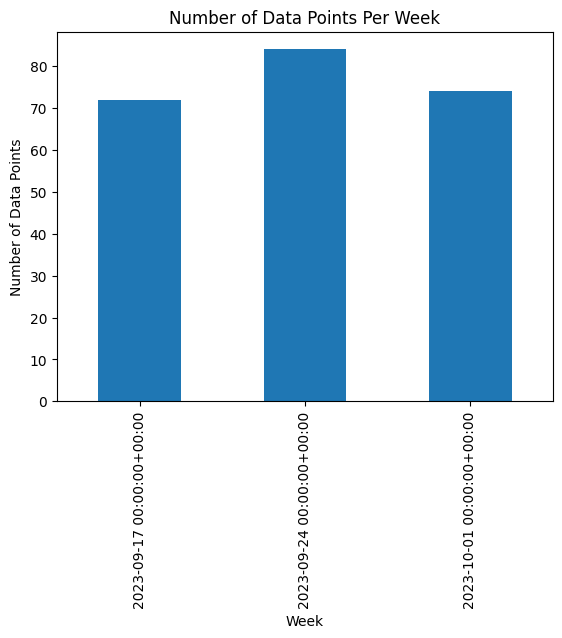

In [16]:
import matplotlib.pyplot as plt

# Resample the DataFrame by week and count the number of data points
weekly_counts = df.resample('W').size()

# Plot the bar chart
weekly_counts.plot(kind='bar')

# Customize the plot
plt.title('Number of Data Points Per Week')
plt.xlabel('Week')
plt.ylabel('Number of Data Points')

# Show the plot
plt.show()

In [19]:
(df["llm"] == "gpt-4").sum()

63

## Investigate retrieved contexts for each request

In [2]:
import psycopg

def retrieve_document(document_id):
    with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
        with conn.cursor() as cur:
            cur.execute("SELECT * FROM document WHERE id = %s", (document_id,))
            row = cur.fetchone()
            return {"document_id": document_id, "text": row[1], "source": row[2]}

In [3]:
idx = -10
print("query:", df.iloc[idx]["query"])
for document_id in df.iloc[idx]["document_ids"]:
    print(retrieve_document(document_id))

NameError: name 'df' is not defined

{'5eca6f77730454941af1e972119557fcfaa426088caf75817b687ae633f0d821': {'document_id': 474,
  'text': 'will limit the size of the object store.\nYou should now see a prompt that looks something like:\nroot@ebc78f68d100:/ray#',
  'source': 'https://docs.ray.io/en/master/installation.html#launch-ray-in-docker'},
 'cc9b3abb3fa5722008193d9af058dcd3db7e3ff2cdcda1f4118a3dd02625d613': {'document_id': 4144,
  'text': 'Object store memory: memory used when your application creates objects in the object store via ray.put and when it returns values from remote functions. Objects are reference counted and evicted when they fall out of scope. An object store server runs on each node. By default, when starting an instance, Ray reserves 30% of available memory. The size of the object store can be controlled by –object-store-memory. The memory is by default allocated to /dev/shm (shared memory) for Linux. For MacOS, Ray uses /tmp (disk), which can impact the performance compared to Linux. In Ray 1.3+, o

In [4]:
import pandas as pd
df = pd.read_csv("../tags.csv")

In [5]:
filtered_df = df[pd.notnull(df['post_content'])]
filtered_df

,post_id,post_content,category_name
0,345,"(post withdrawn by author, will be automatical...",RLlib
1,23438,<!-- Answering the following question will gre...,Ray Tune
2,9804,"Hi @TheExGenesis,\n\nPerhaps this will be ava...",RLlib
3,3126,cc @simon-mo don't you have a way to see the p...,Ray Core
4,5395,"This works, thanks a lot @Dmitri",Kubernetes
...,...,...,...
22947,29612,<!-- Answering the following question will gre...,Ray Core
22948,29786,"Hello,\n\nIf by the working script you mean th...",RLlib
22949,30574,Maybe take a look at this PR which is trying t...,Dashboard
22950,30594,Oh that might be it! It was failing cause I ha...,Dashboard


In [6]:
# Remove uncommon classes
common_categories = set(filtered_df["category_name"].value_counts().keys()[:14])
filtered_df = filtered_df[filtered_df["category_name"].isin(common_categories)]
common_categories

{'Configure Algorithm, Training, Evaluation, Scaling',
 'Dashboard',
 'Kubernetes',
 'Monitoring & Debugging',
 'RLlib',
 'Ray Client',
 'Ray Clusters',
 'Ray Core',
 'Ray Data',
 'Ray Libraries (Data, Train, Tune, Serve)',
 'Ray Serve',
 'Ray Train',
 'Ray Tune',
 'Uncategorized'}

In [39]:
sources_map = {
    "Ray Core": ["ray-core"],
    "Ray Data": ["data"],
    "Ray Train": ["train"],
    "Ray Tune": ["tune"],
    "Ray Serve": ["serve"],
    "RLlib": ["rllib"],
    "Ray Libraries (Data, Train, Tune, Serve)": ["data", "train", "tune", "serve"],
    "Ray Clusters": ["cluster"],
    "Dashboard": ["ray-observability"],
}

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Train classifier
classifier = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("classifier", LogisticRegression(multi_class="multinomial", max_iter=1000, verbose=1))
])
classifier.fit(filtered_df["post_content"], filtered_df["category_name"])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      1047214     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95635D+04    |proj g|=  5.40486D+03


 This problem is unconstrained.



At iterate   50    f=  2.70723D+04    |proj g|=  4.15506D+01

At iterate  100    f=  2.65891D+04    |proj g|=  1.61022D+01

At iterate  150    f=  2.65813D+04    |proj g|=  1.40428D+00

At iterate  200    f=  2.65811D+04    |proj g|=  2.20364D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    204    216      1     0     0   9.998D-02   2.658D+04
  F =   26581.131930177289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    verbose=1))])

In [26]:
questions = """How do I implement logging of custom metrics with every training step?
how to run TorchTrainer on gpu?
can i increment the object store memory size
how to install all ray dependencies at once
how to autoscale on-prem cluster
how to serve code-llama
I used `from ray import train` and now it raises an AttributeError: module 'ray.train' has no attribute 'torch'
what is ray used for
I am planning to take control of the world
Could you give an example of a detachable actor in Ray?
how to rename columns in ray dataset
What's the difference between a task and a job?
How can I train an llm using ray?
how to change num blocks in dataset
what is the difference between ray up and ray start
how can I spin up a heterogeneous cluster? Meaning i want to have a ray cluster with both cpu instance and gpu instance
can I specify a SPREAD scheduling strategy on serve deployments
prepare_trainer
what is the newest version of ray
what is driver process?
I have a Ray Serve Application object. How do I query it?
what GCS stores?
what is ray head service?
cluster wide max workers
How to manually start a ray serve instance for a head node on remote server
if I submit a task, and there is no resource, will it be pending? if so, it will wait in gcs?
how to train model on gpu?
can i increment the object store memory size
How can I run model training on local cluster?
how does LLM sharded?
ray cluster overview
how to install all ray dependencies at once
how ray serve to serve model from hugging face
what are the different Trainers available?
can I use deepspeed with ray serve?
Can you give assignment on Ray serve for basic understanding
connect worker to already existing cluster
How can I set the search algorithm using a tune.Tuner?
How does Ray know how many GPUs a node has?""".split("\n")

preds = classifier.predict(questions)

for i in range(len(preds)):
    print(questions[i], ":", preds[i])

How do I implement logging of custom metrics with every training step? : RLlib
how to run TorchTrainer on gpu? : Ray Libraries (Data, Train, Tune, Serve)
can i increment the object store memory size : Ray Core
how to install all ray dependencies at once : Ray Core
how to autoscale on-prem cluster : Ray Clusters
how to serve code-llama : Ray Serve
I used `from ray import train` and now it raises an AttributeError: module 'ray.train' has no attribute 'torch' : Ray Train
what is ray used for : Ray Core
I am planning to take control of the world : RLlib
Could you give an example of a detachable actor in Ray? : Ray Core
how to rename columns in ray dataset : Ray Data
What's the difference between a task and a job? : Ray Core
How can I train an llm using ray? : Ray Train
how to change num blocks in dataset : Ray Data
what is the difference between ray up and ray start : Ray Core
how can I spin up a heterogeneous cluster? Meaning i want to have a ray cluster with both cpu instance and gpu ins

In [9]:
import json
from rag.generate import QueryAgent
from rag.generate import get_sources_and_context

embedding_model_name="thenlper/gte-large"
llm="meta-llama/Llama-2-70b-chat-hf"
query = "What is the default batch size for map_batches?"
system_content = "Answer the query using the context provided. Be succinct."
agent = QueryAgent(
    embedding_model_name=embedding_model_name,
    llm=llm,
    max_context_length=4096,
    system_content=system_content)
result = agent(query=query, stream=False)
print("\n\n", json.dumps(result, indent=2))

ModuleNotFoundError: No module named 'rag'

In [30]:
query = "how to run TorchTrainer on gpu?"
document_ids, sources, context = get_sources_and_context(
            query=query, embedding_model=agent.embedding_model, num_chunks=10
        )
# preds = classifier.predict_proba([query])
# list(zip(classifier.classes_, preds[0]))
preds = classifier.predict([query])

preds

array(['Ray Libraries (Data, Train, Tune, Serve)'], dtype=object)

In [10]:
import hashlib
import urllib.parse

# Ranking algorithm:
# 1) Dedupe
# 2) Remove one line contexts
# 3) Keep the documents with the right topic

class RankerByCategory:
    def __init__(self, classifier):
        self.classifier = classifier

    def rank(self, query, documents):
        # First deduplicate the documents, using the shortest URL as the canonical source
        unique_docs = {}
        for document in documents:
            h = hashlib.sha256(document["text"].encode()).hexdigest()
            if h not in unique_docs:
                unique_docs[h] = document
            elif len(document["source"]) < len(unique_docs[h]["source"]):
                unique_docs[h] = document

        category, = self.classifier.predict([query])
        print("ranker: using category", category)
        results = []
        for h, doc in unique_docs.items():
            url = urllib.parse.urlparse(doc["source"])
            c = url.path.split("/")[3]
            if c in sources_map[category]:
                results.append(doc)

        return results

ranker = RankerByCategory(classifier)

# documents = []
# for document_id in document_ids:
#     documents.append(retrieve_document(document_id))
# ranker.rank(query, documents)

In [46]:
import rag

# import importlib
# importlib.reload(rag.generate)

import json
from rag.generate import QueryAgent
from rag.generate import get_sources_and_context

embedding_model_name="thenlper/gte-large"
llm="meta-llama/Llama-2-70b-chat-hf"
query = "logging with wandb"
system_content = "Answer the query using the context provided. Be succinct."
agent = QueryAgent(
    embedding_model_name=embedding_model_name,
    llm=llm,
    max_context_length=4096,
    system_content=system_content,
    ranker=ranker)
result = agent(query=query, stream=False)
# print("\n\n", json.dumps(result, indent=2))
print(result["answer"])

ranker: using category Ray Tune
 Sure, here's a succinct answer to the query "logging with wandb" in the context provided:

You can use the `WandbLoggerCallback` class from the `ray.air.integrations.wandb` module to log metrics to Wandb. This class takes various options such as project, group, api_key_file, api_key, excludes, log_config, upload_checkpoints, save_checkpoints, and upload_timeout. You can also use the `setup_wandb` function to configure Wandb for use with Tune.
